# Batch NormalizationとLayer Normalization

## Hook

### .register_hook()

In [11]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from functools import partial
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
a = torch.ones(5, requires_grad = True)
b = 2 * a
b.retain_grad()
b.register_hook(lambda grad: print(grad))
c = b.mean()
c.backward()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])


### .register_forward_hook()

In [63]:
conv_model = nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2
    nn.AdaptiveAvgPool2d(1),
    # 32x1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10)
    # 10
)

outputs = {}
def save_output(name, module, inp, out):
    module_name = f'{name}_{str(module)}'
    outputs[module_name] = out.shape

for name, module in conv_model.named_modules():
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_forward_hook(partial(save_output, name))

In [64]:
def print_hooks(model):
    for name, module in conv_model.named_modules():
        if hasattr(module, '_forward_hooks'):
            for hook in module._forward_hooks.values():
                print(f'Module {name} has forward hook : {hook}' )
    
        if hasattr(module, '_backward_hooks'):
            for hook in module._backward_hooks.values():
                print(f'Module {name} has backward hook : {hook}' )

In [65]:
print_hooks(conv_model)

Module 0 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '0')
Module 1 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '1')
Module 2 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '2')
Module 3 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '3')
Module 4 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '4')
Module 5 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '5')
Module 6 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '6')
Module 7 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '7')
Module 8 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '8')
Module 9 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '9')
Module 10 has forward hook : functools.partial(<function save_output a

In [66]:
# forwardでhook発動
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)

In [67]:
outputs

{'0_Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 4, 14, 14]),
 '1_ReLU()': torch.Size([1, 4, 14, 14]),
 '2_Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 8, 7, 7]),
 '3_ReLU()': torch.Size([1, 8, 7, 7]),
 '4_Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 16, 4, 4]),
 '5_ReLU()': torch.Size([1, 16, 4, 4]),
 '6_Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))': torch.Size([1, 32, 2, 2]),
 '7_ReLU()': torch.Size([1, 32, 2, 2]),
 '8_AdaptiveAvgPool2d(output_size=1)': torch.Size([1, 32, 1, 1]),
 '9_Flatten(start_dim=1, end_dim=-1)': torch.Size([1, 32]),
 '10_Linear(in_features=32, out_features=10, bias=True)': torch.Size([1, 10])}

### .register_full_backward()

In [68]:
grads = {}
def save_grad_in(name, module, grad_in, grad_out):
    module_name = f'{name}_{str(module)}'
    grads[module_name] = grad_in

for name, module in conv_model.named_modules():
    if name: # 自分自身のmoduleにはhookをつけない
        module.register_full_backward_hook(partial(save_grad_in, name))

In [69]:
print_hooks(conv_model)

Module 0 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '0')
Module 0 has backward hook : functools.partial(<function save_grad_in at 0x7fff17b803a0>, '0')
Module 1 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '1')
Module 1 has backward hook : functools.partial(<function save_grad_in at 0x7fff17b803a0>, '1')
Module 2 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '2')
Module 2 has backward hook : functools.partial(<function save_grad_in at 0x7fff17b803a0>, '2')
Module 3 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '3')
Module 3 has backward hook : functools.partial(<function save_grad_in at 0x7fff17b803a0>, '3')
Module 4 has forward hook : functools.partial(<function save_output at 0x7fff17c32040>, '4')
Module 4 has backward hook : functools.partial(<function save_grad_in at 0x7fff17b803a0>, '4')
Module 5 has forward hook : functools.partial(<function save

In [70]:
# backward
X = torch.randn((1, 1, 28, 28))
output = conv_model(X)
loss = output.mean()
loss.backward()

In [71]:
grads

{'10_Linear(in_features=32, out_features=10, bias=True)': (tensor([[ 0.0034, -0.0460, -0.0281,  0.0028, -0.0053,  0.0071,  0.0448, -0.0417,
           -0.0018, -0.0473,  0.0426, -0.0006, -0.0057,  0.0461,  0.0238,  0.0175,
           -0.0006,  0.0119,  0.0072, -0.0404, -0.0292,  0.0393,  0.0059, -0.0123,
           -0.0141, -0.0194,  0.0034,  0.0033, -0.0331,  0.0328,  0.0323,  0.0035]]),),
 '9_Flatten(start_dim=1, end_dim=-1)': (tensor([[[[ 0.0034]],
  
           [[-0.0460]],
  
           [[-0.0281]],
  
           [[ 0.0028]],
  
           [[-0.0053]],
  
           [[ 0.0071]],
  
           [[ 0.0448]],
  
           [[-0.0417]],
  
           [[-0.0018]],
  
           [[-0.0473]],
  
           [[ 0.0426]],
  
           [[-0.0006]],
  
           [[-0.0057]],
  
           [[ 0.0461]],
  
           [[ 0.0238]],
  
           [[ 0.0175]],
  
           [[-0.0006]],
  
           [[ 0.0119]],
  
           [[ 0.0072]],
  
           [[-0.0404]],
  
           [[-0.0292]],
  
 

### Activationの分布

In [2]:
def model():
    return nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    # 32x2x2
    nn.AdaptiveAvgPool2d(1),
    # 32x1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10)
    # 10
)

In [3]:
conv_model = model()

In [30]:
# # forward hook
# act_means = [[] for module in conv_model if isinstance(module, nn.ReLU)]
# act_stds = [[] for module in conv_model if isinstance(module, nn.ReLU)]

# def save_out_stats(i, module, inp, out):
#     act_means[i].append(out.mean().item())
#     act_stds[i].append(out.std().item())

# relu_layers = [module for module in conv_model if isinstance(module, nn.ReLU)]
# for i, relu in enumerate(relu_layers):
#     relu.register_forward_hook(partial(save_out_stats, i))


class ActivationStatistics:
    def __init__(self, model):
        self.model = model
        self.act_means = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.act_stds = [[] for module in self.model if isinstance(module, nn.ReLU)]
        self.register_hook()

    def register_hook(self):
        relu_layers = [module for module in self.model if isinstance(module, nn.ReLU)]
        for i, relu in enumerate(relu_layers):
            relu.register_forward_hook(partial(self.save_out_stats, i))

    def save_out_stats(self, i, module, inp, out):
        self.act_means[i].append(out.detach().cpu().mean().item())
        self.act_stds[i].append(out.detach().cpu().std().item())

    def get_statistics(self):
        return self.act_means, self.act_stds

    def plot_statistics(self):
        fig, axs = plt.subplots(1, 2, figsize=(15, 5))
        for act_mean in self.act_means:
            axs[0].plot(act_mean)
        axs[0].set_title('Activation means')
        axs[0].legend(range(len(self.act_means)))

        for act_std in self.act_stds:
            axs[1].plot(act_std)
        axs[1].set_title('Activation stds')
        axs[1].legend(range(len(self.act_stds)))

        plt.show()

In [5]:
act_stats = ActivationStatistics(conv_model)

In [7]:
# データ準備
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train = True, download = True, transform = transform)
val_dataset = torchvision.datasets.FashionMNIST('./fmnist_data', train = False, download = True, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 1024, shuffle = True, num_workers = 4)
val_loader = DataLoader(val_dataset, batch_size = 1024, shuffle = False, num_workers = 4)

In [13]:
opt = optim.SGD(conv_model.parameters(), lr = 0.03)
train_losses, val_losses, val_accuracies = utils.learn(conv_model, train_loader, val_loader, opt, F.cross_entropy, num_epoch = 10)

epoch: 0: train error: 0.7393942859213231, validation error: 0.7126051843166351, validation accuracy: 0.7235969364643097


epoch: 1: train error: 0.7087517592866542, validation error: 0.7521920919418335, validation accuracy: 0.706427377462387


epoch: 2: train error: 0.7116649322590586, validation error: 0.7039019882678985, validation accuracy: 0.7357581317424774


epoch: 3: train error: 0.6838954535581298, validation error: 0.7735313177108765, validation accuracy: 0.6979691505432128


epoch: 4: train error: 0.6797945256960594, validation error: 0.6870704412460327, validation accuracy: 0.7344288110733033


epoch: 5: train error: 0.6564398084656667, validation error: 0.684339416027069, validation accuracy: 0.7432079076766968


epoch: 6: train error: 0.6490992964324305, validation error: 0.7799464166164398, validation accuracy: 0.6989915490150451


epoch: 7: train error: 0.6514015642263121, validation error: 0.6392801523208618, validation accuracy: 0.7561045110225677


epoch: 8: train error: 0.6292609127901369, validation error: 0.6612243294715882, validation accuracy: 0.7522062361240387


epoch: 9: train error: 0.6295662421291157, validation error: 0.6474114239215851, validation accuracy: 0.7466258764266968


In [14]:
act_means, act_std = act_stats.get_statistics()

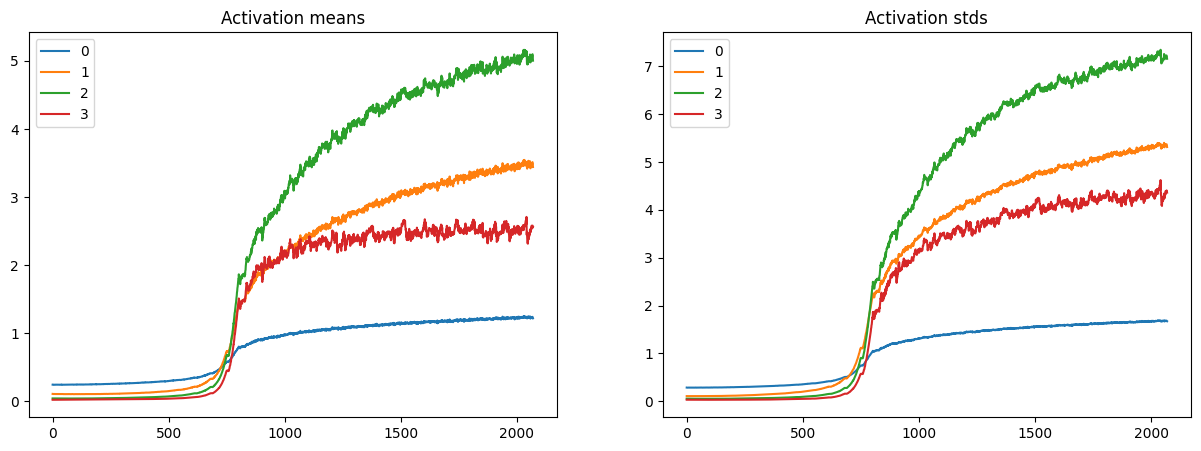

In [15]:
act_stats.plot_statistics()

### Batch Norm スクラッチ実装

In [43]:
# 全結合の場合はX.shape = [b, out_features]
# dim = (0)で平均、分散を求める

def batch_norm(X, gamma=1, beta=0, eps = 1e-5):
    # X = torch.randn(8, 3, 16, 16)
    mean = X.mean(dim = (0, 2, 3), keepdim = True)
    var = X.var(dim = (0, 2, 3), keepdim = True)
    X_norm = (X - mean) / (torch.sqrt(var) + eps)
    return gamma * X_norm + beta

In [10]:
X, y = train_dataset[0]
X.shape

torch.Size([1, 28, 28])

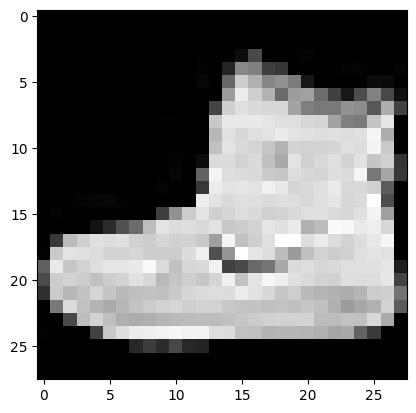

In [13]:
X = X / 2 + 0.5
plt.imshow(np.transpose(X, (1, 2, 0)), cmap = 'gray')

In [17]:
# shape(ランク)を変更させる方法(2次元 -> 4次元)
x = torch.randn(2, 2)
print(x.shape)
x = x[None, None, :, :]
print(x.shape)

torch.Size([2, 2])
torch.Size([1, 1, 2, 2])


### nn.BatchNorm2d

In [24]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1)(X)
norm_out = nn.BatchNorm2d(8)(conv_out)

In [19]:
X.shape

torch.Size([1024, 1, 28, 28])

In [23]:
conv_out.shape

torch.Size([1024, 8, 14, 14])

In [25]:
norm_out.shape

torch.Size([1024, 8, 14, 14])

In [26]:
list(nn.BatchNorm2d(8).parameters())

[Parameter containing:
 tensor([1., 1., 1., 1., 1., 1., 1., 1.], requires_grad=True),
 Parameter containing:
 tensor([0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)]

In [27]:
def get_conv_model():
    return nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(4),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    # 32x2x2
    nn.AdaptiveAvgPool2d(1),
    # 32x1x1
    nn.Flatten(),
    # 32
    nn.Linear(32, 10)
    # 10
)

In [28]:
conv_model_w_bn = get_conv_model()

In [31]:
act_stats = ActivationStatistics(conv_model_w_bn)

In [33]:
opt = optim.SGD(conv_model_w_bn.parameters(), lr = 0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_bn, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 0.8770651726399438, validation error: 0.6119796156883239, validation accuracy: 0.7652224183082581


epoch: 1: train error: 0.4854636631779752, validation error: 0.509335133433342, validation accuracy: 0.8105767726898193


epoch: 2: train error: 0.4123651930841349, validation error: 0.4494589328765869, validation accuracy: 0.8285734236240387


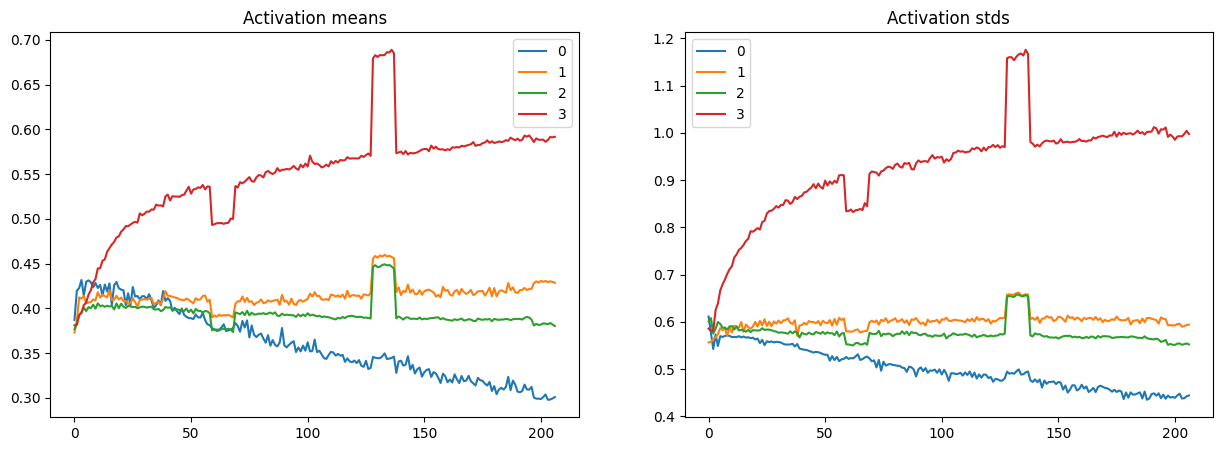

In [36]:
act_stats.plot_statistics()

### Layer Norm スクラッチ実装

In [45]:
X = torch.randn(8, 3, 16, 16)
X.mean(dim = (1, 2, 3), keepdim = True).shape

torch.Size([8, 1, 1, 1])

In [44]:
def LayerNorm(X, gamma=1, beta=0, eps = 1e-5):
    mean = X.mean(dim = (1, 2, 3), keepdim = True)
    std = X.std(dim = (1, 2, 3), keepdim = True)
    normed_out = (X - mean) / std
    return normed_out * gamma + beta

### nn.LayerNorm()

In [47]:
X, y = next(iter(train_loader))
conv_out = nn.Conv2d(1, 8, kernel_size = 3, stride = 2, padding = 1)(X)
norm_out = nn.LayerNorm([8, 14, 14])(conv_out)

In [48]:
conv_out.shape

torch.Size([1024, 8, 14, 14])

In [49]:
norm_out.shape

torch.Size([1024, 8, 14, 14])

In [50]:
def get_conv_model_ln():
    return  nn.Sequential(
    # 1x28x28
    nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([4, 14, 14]),
    nn.ReLU(),
    # 4x14x14
    nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([8, 7, 7]),
    nn.ReLU(),
    # 8x7x7
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([16, 4, 4]),
    nn.ReLU(),
    # 16x4x4
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.LayerNorm([32, 2, 2]),
    nn.ReLU(),
    # 32x2x2 -> GAP -> 32 x 1 x 1
    nn.AdaptiveAvgPool2d(1),
    nn.Flatten(),
    nn.Linear(32, 10)
    # 10
)
conv_model_w_ln = get_conv_model_ln()
act_stats = ActivationStatistics(conv_model_w_ln)
opt = optim.SGD(conv_model_w_ln.parameters(), lr=0.6)
train_losses, val_losses, val_accuracies = utils.learn(conv_model_w_ln, train_loader, val_loader, opt, F.cross_entropy, 3)

epoch: 0: train error: 1.4852899555432595, validation error: 0.9589067816734314, validation accuracy: 0.6443040490150451


epoch: 1: train error: 0.817533272807881, validation error: 0.7359799742698669, validation accuracy: 0.725701528787613


epoch: 2: train error: 0.6343212117583065, validation error: 0.5821177065372467, validation accuracy: 0.7840620994567871


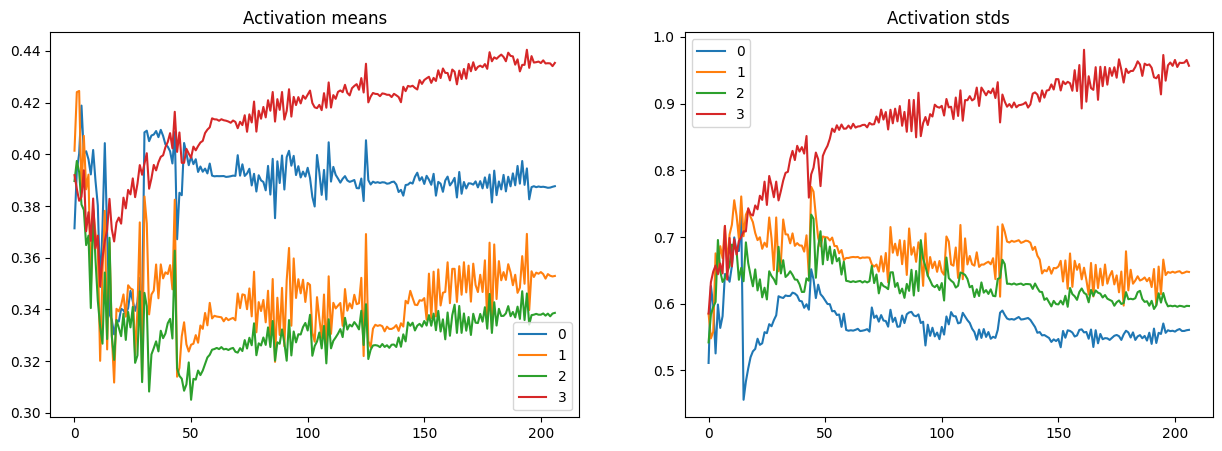

In [51]:
act_stats.plot_statistics()